In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from time import process_time
from scipy.io import loadmat

N = 4

In [2]:
pd = '' #path with data

In [3]:
data = loadmat(pd+'dataAnswer_regular_from_0_to_3pion4.mat')
answers_reg_ = np.transpose(np.array(data['answers']))
data = loadmat(pd+'dataChoi3_n_regular_from_0_to_3pion4.mat')
chois_reg_ = np.array(data['choi'])

data = loadmat(pd+'dataAnswer_regular_otherY_from_0_to_3pion4.mat')
answers_Y = np.transpose(np.array(data['answers']))
data = loadmat(pd+'dataChoi3_n_regular_otherY_from_0_to_3pion4.mat')
chois_Y = np.array(data['choi'])

chois_reg = np.concatenate((chois_reg_, chois_Y), axis=0)
answers_reg = np.concatenate((answers_reg_, answers_Y), axis=0)

data = loadmat(pd+'dataAnswer_regular_3pion8.mat')
answers_other1 = np.transpose(np.array(data['answers']))
data = loadmat(pd+'dataChoi3_n_regular_3pion8.mat')
chois_other1 = np.array(data['choi'])

data = loadmat(pd+'dataAnswer_regular_otherY_3pion8.mat')
answers_other2 = np.transpose(np.array(data['answers']))
data = loadmat(pd+'dataChoi3_n_regular_otherY_3pion8.mat')
chois_other2 = np.array(data['choi'])

chois_other = np.concatenate((chois_other1, chois_other2), axis=0)
answers_other = np.concatenate((answers_other1, answers_other2), axis=0)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.linear_model import Ridge

In [5]:
def resample(X, n):
    X1=[]
    for i in range(0,100,n):
        for j in range(0,50,n):
            X1.append(X[i*50+j]);
    X1 = np.array(X1)
    return X1

def resampleMod(X, n, m):
    X1=[]
    for i in range(0,100,n):
        for j in range(0,50,n):
            if(i % m or j % m):
                X1.append(X[i*50+j]);
    X1 = np.array(X1)
    return X1

In [6]:
chois_reg_small = resample(chois_reg[0:5000], 4);
answers_reg_small = resample(answers_reg[0:5000], 4);
for i in range(5000, len(answers_reg), 5000):
    chois_reg_small=np.concatenate((chois_reg_small, resample(chois_reg[i:i+5000], 4)), axis=0);
    answers_reg_small=np.concatenate((answers_reg_small, resample(answers_reg[i:i+5000], 4)), axis=0);
    
X = chois_reg_small
y = answers_reg_small

print([X.shape, y.shape])

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=.1, random_state=777)

X_other = chois_other
y_other = answers_other
print([y_train.shape, y_test.shape, np.sum(y)/y.size])

[(3900, 27), (3900, 1)]
[(3510, 1), (390, 1), 0.767948717948718]


In [7]:
h = .02 
names = [ "Random Forest    "]
classifiers = [ RandomForestClassifier(max_depth=5, n_estimators=50)]

In [8]:
name = names[0]
clf = classifiers[0]
clf.fit(X_train, y_train)
score_all = clf.score(chois_reg, answers_reg)
score0 = clf.score(chois_reg_small, answers_reg_small)
score = clf.score(chois_reg, answers_reg)
score_other = clf.score(X_other, y_other)
y_t = clf.predict(X_train)
y_p = clf.predict(X_other)
f1_t = metrics.f1_score(y_train, y_t)
f1_p = metrics.f1_score(y_other, y_p)
auc_t = metrics.roc_auc_score(y_train, y_t)
auc_p = metrics.roc_auc_score(y_other, y_p)
print((name+"   {:.3f};   {:.3f};   {:.3f};   {:.3f};   {:.3f};   {:.3f};   {:.3f};   {:.3f}").format(score_all, score0, score, score_other, f1_t, f1_p, auc_t, auc_p))

Random Forest       0.864;   0.947;   0.864;   0.889;   0.966;   0.926;   0.910;   0.832


In [9]:
print([(y_t.reshape(y_t.size)!=y_train.reshape(y_t.size)).shape, X_train.shape])
x_train_false = X_train[np.transpose(np.tile(y_t.reshape(y_t.size)!=y_train.reshape(y_t.size), (X_train.shape[1], 1)))].reshape(-1,27)
x_train_true = X_train[np.transpose(np.tile(y_t.reshape(y_t.size)==y_train.reshape(y_t.size), (X_train.shape[1], 1)))].reshape(-1,27)
x_proba_false = clf.predict_proba(x_train_false)
x_proba_true = clf.predict_proba(x_train_true)

[(3510,), (3510, 27)]


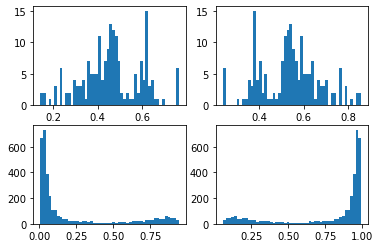

In [10]:
import matplotlib.pyplot as plt
plt.subplot(2, 2, 1)
n, bins, patches = plt.hist(x_proba_false[:,0], 50)
plt.subplot(2, 2, 2)
n, bins, patches = plt.hist(x_proba_false[:,1], 50)
plt.subplot(2, 2, 3)
n, bins, patches = plt.hist(x_proba_true[:,0], 50)
plt.subplot(2, 2, 4)
n, bins, patches = plt.hist(x_proba_true[:,1], 50)
plt.show()

In [11]:
X_train_cor = np.concatenate((X_train, clf.predict_proba(X_train)), axis=1)
X_test_cor = np.concatenate((X_test, clf.predict_proba(X_test)), axis=1)
X_other_cor = np.concatenate((X_other, clf.predict_proba(X_other)), axis=1)
y_train_cor = clf.predict(X_train).reshape(y_train.size)!=y_train.reshape(y_train.size)
y_test_cor = clf.predict(X_test).reshape(y_test.size)!=y_test.reshape(y_test.size)
y_other_cor = clf.predict(X_other).reshape(y_other.size)!=y_other.reshape(y_other.size)


In [12]:
names_cor = [
    "Nearest Neighbors", 
    "Linear SVM       ",
    "Poly SVM         ",
    "sigmoid SVM      ",
    "RBF SVM          ", 
    "Decision Tree    ",
    "Random Forest    ",
    "Neural Net       ",
    "AdaBoost         ",
    "Naive Bayes      ",
    "LDA              ",
    "QDA              "
    ]

classifiers_cor = [ 
    KNeighborsClassifier(3),
    SVC(kernel="linear"),
    SVC(kernel="poly", degree=3),
    SVC(kernel="sigmoid"),
    SVC(),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=100),
    MLPClassifier(alpha=0.01,hidden_layer_sizes=[32, 8]),
    AdaBoostClassifier(DecisionTreeClassifier(max_depth=5), n_estimators=100),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis() 
    ]

In [13]:
for name_cor, clf_cor in zip(names_cor, classifiers_cor):
    clf_cor.fit(X_train_cor, y_train_cor)
    score0 = clf_cor.score(X_train_cor, y_train_cor)
    score = clf_cor.score(X_test_cor, y_test_cor)
    score_other = clf_cor.score(X_other_cor, y_other_cor)
    y_t = clf_cor.predict(X_train_cor)
    y_p = clf_cor.predict(X_other_cor)
    
    
    f1_t = metrics.f1_score(y_train_cor, y_t)
    f1_p = metrics.f1_score(y_other_cor, y_p)
    auc_t = metrics.roc_auc_score(y_train_cor, y_t)
    auc_p = metrics.roc_auc_score(y_other_cor, y_p)
    
    print((name_cor+"   {:.5f};   {:.5f};   {:.5f};   {:.5f};   {:.5f};   {:.5f};   {:.5f}").format(score0, score, score_other, f1_t, f1_p, auc_t, auc_p))    

Nearest Neighbors   0.98433;   0.95128;   0.92940;   0.84330;   0.62764;   0.89729;   0.75765
Linear SVM          0.94729;   0.94359;   0.88920;   0.00000;   0.00000;   0.50000;   0.50000
Poly SVM            0.94729;   0.94359;   0.88920;   0.00000;   0.00000;   0.50000;   0.50000
sigmoid SVM         0.94729;   0.94359;   0.88920;   0.00000;   0.00000;   0.50000;   0.50000
RBF SVM             0.94729;   0.94359;   0.88920;   0.00000;   0.00000;   0.50000;   0.50000
Decision Tree       0.97550;   0.94615;   0.86420;   0.74706;   0.30359;   0.83903;   0.60287
Random Forest       0.95983;   0.94872;   0.89050;   0.38428;   0.02493;   0.61892;   0.50626
Neural Net          0.95869;   0.95641;   0.92380;   0.55927;   0.62757;   0.74083;   0.77307
AdaBoost            1.00000;   0.97179;   0.89940;   1.00000;   0.24361;   1.00000;   0.56973
Naive Bayes         0.78860;   0.75897;   0.71060;   0.32299;   0.42738;   0.86800;   0.82621
LDA                 0.94644;   0.94103;   0.88880;   0.05051

In [14]:
clf_cor = DecisionTreeClassifier(max_depth=5)
clf_cor.fit(X_train_cor, y_train_cor)

answer_nn = clf.predict(chois_reg)
answer_o = clf.predict(chois_other)
clf_proba = clf.predict_proba(chois_reg)[:, 0]
clf_proba = np.logical_and(clf_proba > 0.4, clf_proba < 0.6)
clf_proba_o = clf.predict_proba(chois_other)[:, 0]
clf_proba_o = np.logical_and(clf_proba_o > 0.4, clf_proba_o < 0.6)

chois_reg_cor = np.concatenate((chois_reg, clf.predict_proba(chois_reg)), axis=1)
answer_cor = clf_cor.predict(chois_reg_cor)

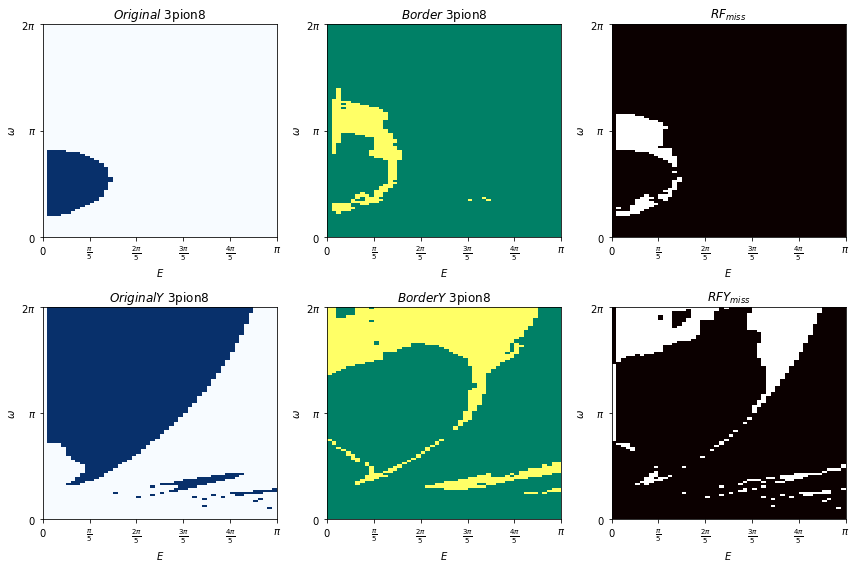

In [15]:
def plt_text():
    plt.xticks([0, 10, 20, 30, 40, 50],[r'$0$',r'$\frac{\pi}{5}$',r'$\frac{2\pi}{5}$',r'$\frac{3\pi}{5}$',r'$\frac{4\pi}{5}$',r'$\pi$'])
    plt.yticks([0, 50, 100],[r'$0$',r'$\pi$',r'$2\pi$'])
    plt.xlabel(r'$E$')
    plt.ylabel(r'$\omega$')


plt.rcParams['figure.figsize'] = (12, 8)
N1 = 0
N2 = 5000

ax = plt.subplot(231)
c = ax.pcolormesh(np.transpose(np.reshape(answers_other[N1:N1+5000], (50,100))), cmap='Blues_r')
plt_text()
ax.set_title(r'$Original$ 3pion8')

ax = plt.subplot(234)
c = ax.pcolormesh(np.transpose(np.reshape(answers_other[N2:N2+5000], (50,100))), cmap='Blues_r')
plt_text()
ax.set_title(r'$Original Y$ 3pion8')

ax = plt.subplot(232)
c = ax.pcolormesh(np.transpose(np.reshape(clf_proba_o[N1:N1+5000], (50,100))), cmap='summer')
plt_text()
ax.set_title(r'$Border$ 3pion8')

ax = plt.subplot(235)
c = ax.pcolormesh(np.transpose(np.reshape(clf_proba_o[N2:N2+5000], (50,100))), cmap='summer')
plt_text()
ax.set_title(r'$Border Y$ 3pion8')


miss = np.transpose(np.logical_xor(answer_o, np.transpose(answers_other)))
ax = plt.subplot(233)
c = ax.pcolormesh(np.transpose(np.reshape(miss[N1:N1+5000], (50,100))), cmap='hot')
plt_text()
ax.set_title(r'$RF_{miss}$')

ax = plt.subplot(236)
c = ax.pcolormesh(np.transpose(np.reshape(miss[N2:N2+5000], (50,100))), cmap='hot')
plt_text()
ax.set_title(r'$RF Y_{miss}$')
'''
ax = plt.subplot(247)
c = ax.pcolormesh(np.transpose(np.reshape(answer_cor[N1:N1+5000], (50,100))), cmap='summer')
plt_text()
ax.set_title(r'$Cor$')

ax = plt.subplot(248)
c = ax.pcolormesh(np.transpose(np.reshape(answer_cor[N2:N2+5000], (50,100))), cmap='summer')
plt_text()
ax.set_title(r'$Cor Y$')
'''

plt.tight_layout()
plt.show()

In [16]:
answer_rf_other = clf.predict(chois_other)
clf_proba_other = clf.predict_proba(chois_other)[:, 0]
clf_proba_other = np.logical_and(clf_proba_other > 0.4, clf_proba_other < 0.6)

chois_other_cor = np.concatenate((chois_other, clf.predict_proba(chois_other)), axis=1)
answer_other_cor = clf_cor.predict(chois_other_cor)

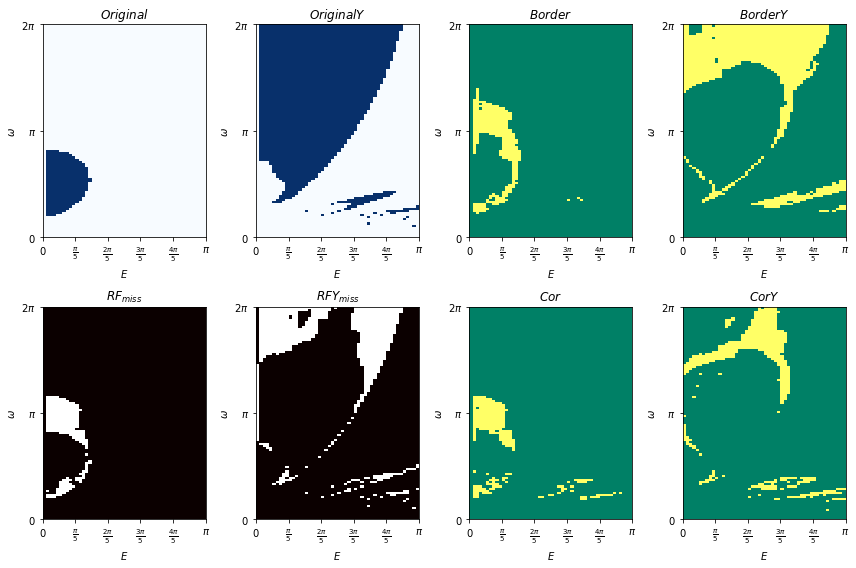

In [17]:

ax = plt.subplot(241)
c = ax.pcolormesh(np.transpose(np.reshape(answers_other[0:5000], (50,100))), cmap='Blues_r')
plt_text()
ax.set_title(r'$Original$')

ax = plt.subplot(242)
c = ax.pcolormesh(np.transpose(np.reshape(answers_other[5000:10000], (50,100))), cmap='Blues_r')
plt_text()
ax.set_title(r'$Original Y$')

ax = plt.subplot(243)
c = ax.pcolormesh(np.transpose(np.reshape(clf_proba_other[0:5000], (50,100))), cmap='summer')
plt_text()
ax.set_title(r'$Border$')

ax = plt.subplot(244)
c = ax.pcolormesh(np.transpose(np.reshape(clf_proba_other[5000:10000], (50,100))), cmap='summer')
plt_text()
ax.set_title(r'$Border Y$')


miss = np.transpose(np.logical_xor(answer_rf_other, np.transpose(answers_other)))
ax = plt.subplot(245)
c = ax.pcolormesh(np.transpose(np.reshape(miss[0:5000], (50,100))), cmap='hot')
plt_text()
ax.set_title(r'$RF_{miss}$')

ax = plt.subplot(246)
c = ax.pcolormesh(np.transpose(np.reshape(miss[5000:10000], (50,100))), cmap='hot')
plt_text()
ax.set_title(r'$RF Y_{miss}$')

ax = plt.subplot(247)
c = ax.pcolormesh(np.transpose(np.reshape(answer_other_cor[0:5000], (50,100))), cmap='summer')
plt_text()
ax.set_title(r'$Cor$')

ax = plt.subplot(248)
c = ax.pcolormesh(np.transpose(np.reshape(answer_other_cor[5000:10000], (50,100))), cmap='summer')
plt_text()
ax.set_title(r'$Cor Y$')

plt.tight_layout()
plt.show()

In [18]:
chois_reg_2 = resample(chois_reg[0:5000], 2);
answers_reg_2 = resample(answers_reg[0:5000], 2);
for i in range(5000, len(answers_reg), 5000):
    chois_reg_2=np.concatenate((chois_reg_2, resample(chois_reg[i:i+5000], 2)), axis=0);
    answers_reg_2=np.concatenate((answers_reg_2, resample(answers_reg[i:i+5000], 2)), axis=0);
print(chois_reg_2.shape)
clf_proba_sup = clf.predict_proba(chois_reg_2)[:, 0]
clf_proba_sup = np.logical_and(clf_proba_sup > 0.4, clf_proba_sup < 0.6)
chois_new = chois_reg_2[clf_proba_sup]
answers_new = answers_reg_2[clf_proba_sup]
print(chois_new.shape)

chois_new = np.concatenate((chois_new, chois_reg_small), axis=0)
answers_new = np.concatenate((answers_new, answers_reg_small), axis=0)
chois_new, indices = np.unique(chois_new, axis = 0, return_index=True)
answers_new = answers_new[indices]
print ((chois_new.shape, chois_reg_small.shape))

(15000, 27)
(924, 27)
((4471, 27), (3900, 27))


In [19]:

X2 = chois_new
y2 = answers_new

print([X.shape, y.shape])

X_train, X_test, y_train, y_test = \
    train_test_split(X2, y2, test_size=.1, random_state=777)

X_other = chois_other
y_other = answers_other
print([y_train.shape, y_test.shape, np.sum(y)/y.size])
name = names[0]
clf2 = classifiers[0]
clf2.fit(X_train, y_train)
score_all = clf2.score(chois_reg, answers_reg)
score0 = clf.score(chois_reg_small, answers_reg_small)
score = clf.score(chois_reg_2, answers_reg_2)
score_other = clf2.score(X_other, y_other)
y_t = clf2.predict(X_train)
y_p = clf2.predict(X_other)
f1_t = metrics.f1_score(y_train, y_t)
f1_p = metrics.f1_score(y_other, y_p)
auc_t = metrics.roc_auc_score(y_train, y_t)
auc_p = metrics.roc_auc_score(y_other, y_p)
print((name+"   {:.3f};   {:.3f};   {:.3f};   {:.3f};   {:.3f};   {:.3f};   {:.3f};   {:.3f}").format(score_all, score0, score, score_other, f1_t, f1_p, auc_t, auc_p))

[(3900, 27), (3900, 1)]
[(4023, 1), (448, 1), 0.767948717948718]
Random Forest       0.930;   0.965;   0.963;   0.934;   0.968;   0.953;   0.952;   0.920


In [20]:

answer2_nn = clf2.predict(chois_reg)
answer2_o = clf2.predict(chois_other)
clf2_proba = clf2.predict_proba(chois_reg)[:, 0]
clf2_proba = np.logical_and(clf2_proba > 0.4, clf2_proba < 0.6)
clf2_proba_o = clf2.predict_proba(chois_other)[:, 0]
clf2_proba_o = np.logical_and(clf2_proba_o > 0.4, clf2_proba_o < 0.6)

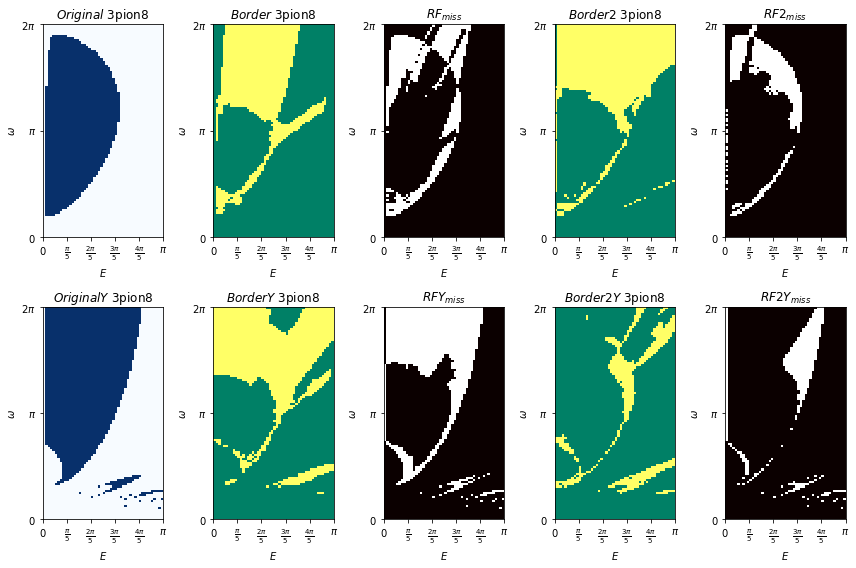

In [21]:
def plt_text():
    plt.xticks([0, 10, 20, 30, 40, 50],[r'$0$',r'$\frac{\pi}{5}$',r'$\frac{2\pi}{5}$',r'$\frac{3\pi}{5}$',r'$\frac{4\pi}{5}$',r'$\pi$'])
    plt.yticks([0, 50, 100],[r'$0$',r'$\pi$',r'$2\pi$'])
    plt.xlabel(r'$E$')
    plt.ylabel(r'$\omega$')


plt.rcParams['figure.figsize'] = (12, 8)
N1 = 0
N2 = 30000

ax = plt.subplot(251)
c = ax.pcolormesh(np.transpose(np.reshape(answers_reg[N1:N1+5000], (50,100))), cmap='Blues_r')
plt_text()
ax.set_title(r'$Original$ 3pion8')

ax = plt.subplot(256)
c = ax.pcolormesh(np.transpose(np.reshape(answers_reg[N2:N2+5000], (50,100))), cmap='Blues_r')
plt_text()
ax.set_title(r'$Original Y$ 3pion8')

ax = plt.subplot(252)
c = ax.pcolormesh(np.transpose(np.reshape(clf_proba[N1:N1+5000], (50,100))), cmap='summer')
plt_text()
ax.set_title(r'$Border$ 3pion8')

ax = plt.subplot(257)
c = ax.pcolormesh(np.transpose(np.reshape(clf_proba[N2:N2+5000], (50,100))), cmap='summer')
plt_text()
ax.set_title(r'$Border Y$ 3pion8')


miss = np.transpose(np.logical_xor(answer_nn, np.transpose(answers_reg)))
ax = plt.subplot(253)
c = ax.pcolormesh(np.transpose(np.reshape(miss[N1:N1+5000], (50,100))), cmap='hot')
plt_text()
ax.set_title(r'$RF_{miss}$')

ax = plt.subplot(258)
c = ax.pcolormesh(np.transpose(np.reshape(miss[N2:N2+5000], (50,100))), cmap='hot')
plt_text()
ax.set_title(r'$RF Y_{miss}$')



ax = plt.subplot(254)
c = ax.pcolormesh(np.transpose(np.reshape(clf2_proba[N1:N1+5000], (50,100))), cmap='summer')
plt_text()
ax.set_title(r'$Border2$ 3pion8')

ax = plt.subplot(259)
c = ax.pcolormesh(np.transpose(np.reshape(clf2_proba[N2:N2+5000], (50,100))), cmap='summer')
plt_text()
ax.set_title(r'$Border2 Y$ 3pion8')


miss = np.transpose(np.logical_xor(answer2_nn, np.transpose(answers_reg)))
ax = plt.subplot(255)
c = ax.pcolormesh(np.transpose(np.reshape(miss[N1:N1+5000], (50,100))), cmap='hot')
plt_text()
ax.set_title(r'$RF2_{miss}$')

ax = plt.subplot(2,5,10)
c = ax.pcolormesh(np.transpose(np.reshape(miss[N2:N2+5000], (50,100))), cmap='hot')
plt_text()
ax.set_title(r'$RF2 Y_{miss}$')
plt.tight_layout()
plt.show()

In [22]:
clf_proba_sup = clf2.predict_proba(chois_reg)[:, 0]
clf_proba_sup = np.logical_and(clf_proba_sup > 0.4, clf_proba_sup < 0.6)
chois_new2 = chois_reg[clf_proba_sup]
answers_new2 = answers_reg[clf_proba_sup]
print(chois_new2.shape)

chois_new2 = np.concatenate((chois_new2, chois_new), axis=0)
answers_new2 = np.concatenate((answers_new2, answers_new), axis=0)
chois_new2, indices = np.unique(chois_new2, axis = 0, return_index=True)
answers_new2 = answers_new2[indices]
print ((chois_new2.shape, chois_new.shape))

(8608, 27)
((12225, 27), (4471, 27))


In [23]:

X3 = chois_new2
y3 = answers_new2

print([X3.shape, y3.shape])

X_train, X_test, y_train, y_test = \
    train_test_split(X3, y3, test_size=.1, random_state=777)

print([y_train.shape, y_test.shape, np.sum(y)/y.size])
name = names[0]
clf3 = classifiers[0]
clf3.fit(X_train, y_train)
score_all = clf3.score(chois_reg, answers_reg)
score0 = clf.score(chois_reg_small, answers_reg_small)
score = clf.score(chois_reg_2, answers_reg_2)
score_other = clf3.score(X_other, y_other)
y_t = clf3.predict(X_train)
y_p = clf3.predict(X_other)
f1_t = metrics.f1_score(y_train, y_t)
f1_p = metrics.f1_score(y_other, y_p)
auc_t = metrics.roc_auc_score(y_train, y_t)
auc_p = metrics.roc_auc_score(y_other, y_p)
print((name+"   {:.3f};   {:.3f};   {:.3f};   {:.3f};   {:.3f};   {:.3f};   {:.3f};   {:.3f}").format(score_all, score0, score, score_other, f1_t, f1_p, auc_t, auc_p))

[(12225, 27), (12225, 1)]
[(11002, 1), (1223, 1), 0.767948717948718]
Random Forest       0.941;   0.939;   0.941;   0.965;   0.921;   0.976;   0.911;   0.960


In [24]:

answer3_nn = clf3.predict(chois_reg)
answer3_o = clf3.predict(chois_other)
clf3_proba = clf3.predict_proba(chois_reg)[:, 0]
clf3_proba = np.logical_and(clf3_proba > 0.4, clf3_proba < 0.6)
clf3_proba_o = clf3.predict_proba(chois_other)[:, 0]
clf3_proba_o = np.logical_and(clf3_proba_o > 0.4, clf3_proba_o < 0.6)

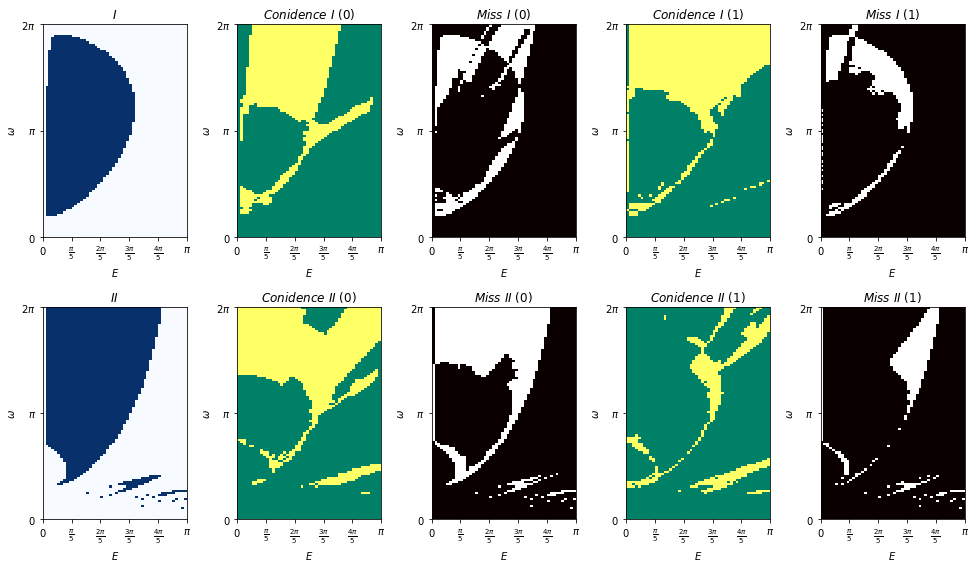

In [39]:
def plt_text():
    plt.xticks([0, 10, 20, 30, 40, 50],[r'$0$',r'$\frac{\pi}{5}$',r'$\frac{2\pi}{5}$',r'$\frac{3\pi}{5}$',r'$\frac{4\pi}{5}$',r'$\pi$'])
    plt.yticks([0, 50, 100],[r'$0$',r'$\pi$',r'$2\pi$'])
    plt.xlabel(r'$E$')
    plt.ylabel(r'$\omega$')


plt.rcParams['figure.figsize'] = (19, 8)
N1 = 0
N2 = 30000

ax = plt.subplot(271)
c = ax.pcolormesh(np.transpose(np.reshape(answers_reg[N1:N1+5000], (50,100))), cmap='Blues_r')
plt_text()
ax.set_title(r'$I$')

ax = plt.subplot(278)
c = ax.pcolormesh(np.transpose(np.reshape(answers_reg[N2:N2+5000], (50,100))), cmap='Blues_r')
plt_text()
ax.set_title(r'$II$')

ax = plt.subplot(272)
c = ax.pcolormesh(np.transpose(np.reshape(clf_proba[N1:N1+5000], (50,100))), cmap='summer')
plt_text()
ax.set_title(r'$Conidence$ $I$ $(0)$')

ax = plt.subplot(279)
c = ax.pcolormesh(np.transpose(np.reshape(clf_proba[N2:N2+5000], (50,100))), cmap='summer')
plt_text()
ax.set_title(r'$Conidence$ $II$ $(0)$')


miss = np.transpose(np.logical_xor(answer_nn, np.transpose(answers_reg)))
ax = plt.subplot(273)
c = ax.pcolormesh(np.transpose(np.reshape(miss[N1:N1+5000], (50,100))), cmap='hot')
plt_text()
ax.set_title(r'$Miss$ $I$ $(0)$')

ax = plt.subplot(2,7,10)
c = ax.pcolormesh(np.transpose(np.reshape(miss[N2:N2+5000], (50,100))), cmap='hot')
plt_text()
ax.set_title(r'$Miss$ $II$ $(0)$')



ax = plt.subplot(274)
c = ax.pcolormesh(np.transpose(np.reshape(clf2_proba[N1:N1+5000], (50,100))), cmap='summer')
plt_text()
ax.set_title(r'$Conidence$ $I$ $(1)$')

ax = plt.subplot(2,7,11)
c = ax.pcolormesh(np.transpose(np.reshape(clf2_proba[N2:N2+5000], (50,100))), cmap='summer')
plt_text()
ax.set_title(r'$Conidence$ $II$ $(1)$')


miss = np.transpose(np.logical_xor(answer2_nn, np.transpose(answers_reg)))
ax = plt.subplot(275)
c = ax.pcolormesh(np.transpose(np.reshape(miss[N1:N1+5000], (50,100))), cmap='hot')
plt_text()
ax.set_title(r'$Miss$ $I$ $(1)$')

ax = plt.subplot(2,7,12)
c = ax.pcolormesh(np.transpose(np.reshape(miss[N2:N2+5000], (50,100))), cmap='hot')
plt_text()
ax.set_title(r'$Miss$ $II$ $(1)$')
plt.tight_layout()
plt.show()




In [ ]:

X_all = chois_reg
y_all = answers_reg

print([X_all.shape, y_all.shape])

X_train, X_test, y_train, y_test = \
    train_test_split(X_all, y_all, test_size=.1, random_state=777)

print([y_train.shape, y_test.shape, np.sum(y)/y.size])

name = names[0]
clf_all = classifiers[0]
clf_all.fit(chois_reg, answers_reg)
score_all = clf_all.score(chois_reg, answers_reg)
score0 = clf.score(chois_reg_small, answers_reg_small)
score = clf.score(chois_reg_2, answers_reg_2)
score_other = clf_all.score(X_other, y_other)
y_t = clf_all.predict(X_train)
y_p = clf_all.predict(X_other)
f1_t = metrics.f1_score(y_train, y_t)
f1_p = metrics.f1_score(y_other, y_p)
auc_t = metrics.roc_auc_score(y_train, y_t)
auc_p = metrics.roc_auc_score(y_other, y_p)
print((name+"   {:.3f};   {:.3f};   {:.3f};   {:.3f};   {:.3f};   {:.3f};   {:.3f};   {:.3f}").format(score_all, score0, score, score_other, f1_t, f1_p, auc_t, auc_p))